# Ch05-2. 교차 검증과 그리드 서치

In [13]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [14]:
data = wine[['alcohol', 'sugar', 'pH']]
target = wine['class']

In [15]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42
)
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


In [16]:
# 훈련 세트를 한번 더 나눔
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [17]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


### 교차 검증

**교차 검증**
- 검증 세트를 떼어 내어 평가 과정을 여러 번 반복
- 반복한 점수를 평균하여 최종 검증 점수를 얻음
- 3-폴드 교차 검증 예시
    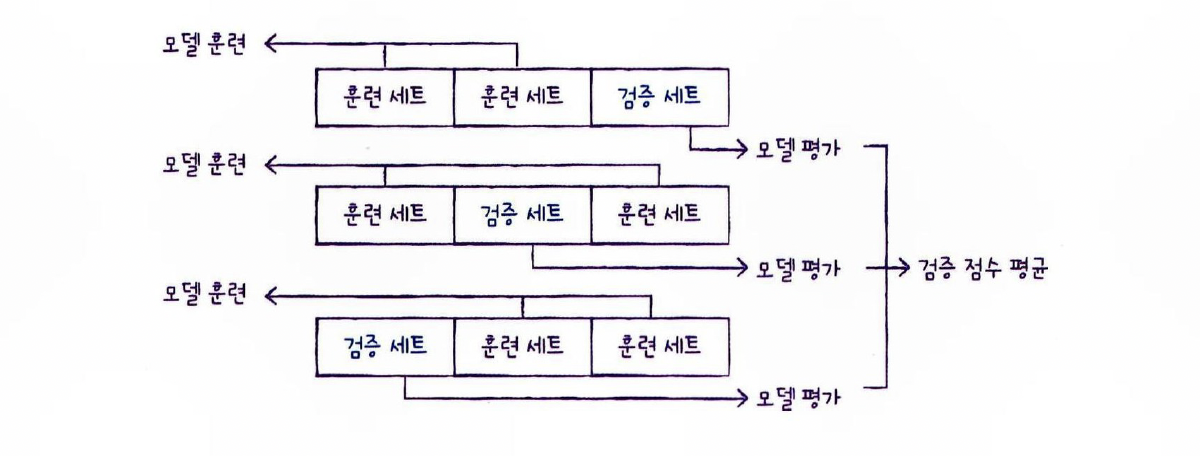

In [18]:
from sklearn.model_selection import cross_validate
scores = cross_validate(
    dt, train_input, train_target)
print(scores)

{'fit_time': array([0.0116992 , 0.01046515, 0.0232749 , 0.02432275, 0.01086092]), 'score_time': array([0.00215888, 0.00211406, 0.00215602, 0.00228024, 0.00189114]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


`fit_time` : 모델 훈련 시간

`score_time` : 검증 시간

`test_score` : 검증 폴드 점수

In [19]:
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


In [ ]:
# 분할기 
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(
    dt, train_input, train_target, cv=StratifiedKFold()
)
print(np.mean(scores['test_score']))

0.855300214703487


In [21]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(
    dt, train_input, train_target, cv=splitter
)
print(np.mean(scores['test_score']))

0.8574181117533719


### 하이퍼파라미너 튜닝

기본값을 그대로 사용해 모델 훈련 후,

그 다음 검증 세트의 점수나 교차 검증을 통해 매개변수를 조금씩 바꿔보기.

=> **그리드 서치(Grid Search)**

In [22]:
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [23]:
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42), params, n_jobs=-1
)
gs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'min_impurity_decrease': [0.0001, 0.0002, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


`min_impurity_decrease` 값을 바꿔가며 결정 트리 모델을 사용해 교차 검증을 총 5번 실행

`n_jobs=-1` : 병렬 실행에 사용할 CPU 코어 수 지정. `-1`은 모든 코어 사용. (default: 1)

In [ ]:
# 교차 검증 점수가 가장 높은 모델의 매개변수 조합으로 훈련됨.
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [ ]:
# 최적의 매개변수
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [27]:
# 각 매개변수에서 수행한 교차 검증의 평균 점수
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [ ]:
# 가장 높은 값의 인덱스를 구하여 매개변수 출력
print(gs.best_index_)
print(gs.cv_results_['params'])
print(gs.cv_results_['params'][gs.best_index_])

0
[{'min_impurity_decrease': 0.0001}, {'min_impurity_decrease': 0.0002}, {'min_impurity_decrease': 0.0003}, {'min_impurity_decrease': 0.0004}, {'min_impurity_decrease': 0.0005}]
{'min_impurity_decrease': 0.0001}


In [34]:
params = {'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001),
          'max_depth' : range(5, 20, 1),
          'min_samples_split' : range(2, 100, 10)
          }
params

{'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
        0.0009]),
 'max_depth': range(5, 20),
 'min_samples_split': range(2, 100, 10)}

In [35]:
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42), params, n_jobs=-1
)
gs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': range(5, 20), 'min_impurity_decrease': array([0.0001... 0.0009]), 'min_samples_split': range(2, 100, 10)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [36]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': np.float64(0.0004), 'min_samples_split': 12}


In [37]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤 서치

In [ ]:
from scipy.stats import uniform, randint

`randint` : 주어진 범위에서 고르게 정수값을 뽑음.

`uniform` : 주어진 범위에서 고르게 실수값을 뽑음.

In [39]:
rgen = randint(0, 10)
rgen.rvs(10)

array([6, 8, 0, 7, 6, 0, 4, 4, 9, 5])

In [40]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 95, 107,  98,  96, 107, 105, 104,  96,  88, 104]))

In [41]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.80717457, 0.49041175, 0.70179188, 0.06637755, 0.7968469 ,
       0.81259861, 0.76663735, 0.42513392, 0.47929356, 0.54922958])

In [43]:
params = {'min_impurity_decrease' : uniform(0.0001, 0.001),
          'max_depth' : randint(20, 50),
          'min_samples_split' : randint(2, 25),
          'min_samples_leaf' : randint(1, 25)
          }
params

{'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fdaf240f130>,
 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fdaf2472c20>,
 'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fdaf25c7a90>,
 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fdaf24721d0>}

In [44]:
from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    params,
    n_iter=100,
    n_jobs=-1,
    random_state=42
)
rs.fit(train_input, train_target)

,estimator,DecisionTreeC...ndom_state=42)
,param_distributions,"{'max_depth': <scipy.stats....x7fdaf2472c20>, 'min_impurity_decrease': <scipy.stats....x7fdaf240f130>, 'min_samples_leaf': <scipy.stats....x7fdaf24721d0>, 'min_samples_split': <scipy.stats....x7fdaf25c7a90>}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [45]:
print(rs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': np.float64(0.00034102546602601173), 'min_samples_leaf': 7, 'min_samples_split': 13}


In [46]:
print(np.max(rs.cv_results_['mean_test_score']))

0.8695428296438884


In [48]:
dt = rs.best_estimator_
print(dt.score(test_input, test_target))

0.86
